In [1]:
import os
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.utils import class_weight
import math 

from keras.applications import xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers

!pip install split-folders #to slpit the dataset in training-validation-test
import splitfolders

In [2]:
# Random fixed seed for reproducibility
seed = 2113

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Dataset and training folders
#dataset_dir = '/kaggle/input/leafdataset-under'
dataset_dir = '../input/leafsdatasetunder/leafdataset-under'
train_dir = os.path.join(dataset_dir, 'train')
labels = [
    "Apple",
    "Blueberry",
    "Cherry",
    "Corn",
    "Grape",
    "Orange",
    "Peach",
    "Pepper",
    "Potato",
    "Raspberry",
    "Soybean",
    "Squash",
    "Strawberry",
    "Tomato"
]

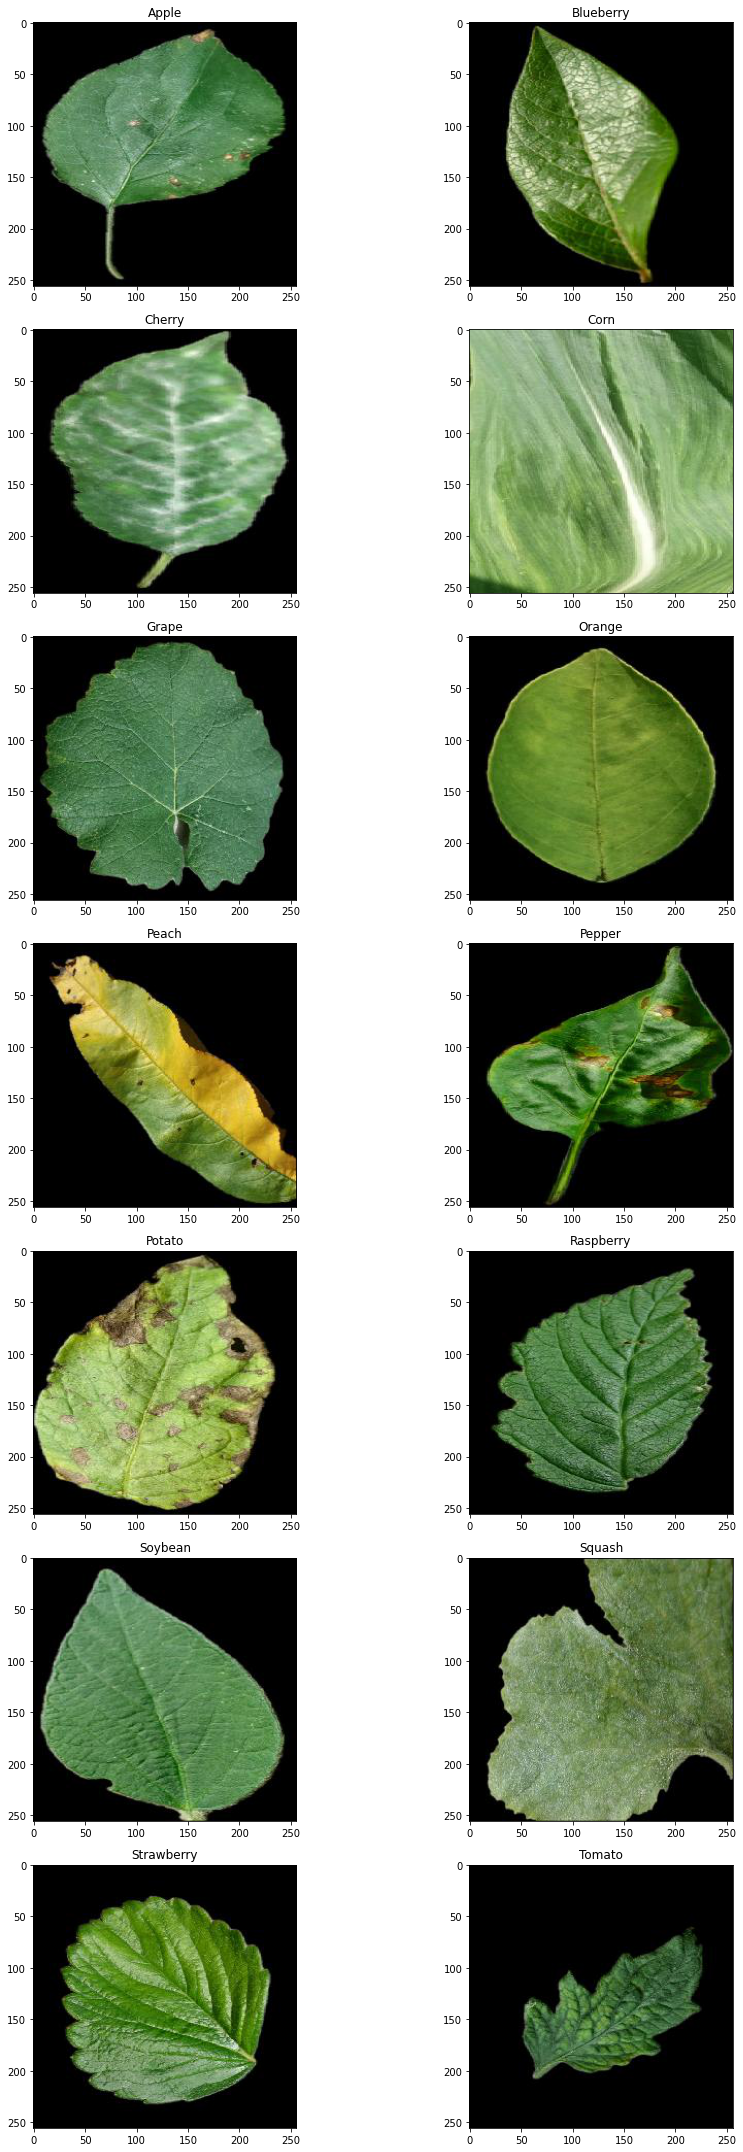

In [4]:
# Plot example images from dataset

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(train_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(train_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

# Dataset preprocessing
We used the metohd 'ratio' of the splitfoldres library to divide the dataset into training, validation and test sets. We decided to keep a 70% of the dataset for the training in order to obtain a well-trained model, a validation of 20% in order to keep track of the model's behaviour on a different set of data during training and also, even if not required, we decided to use part of the data (10%) for testing the performance of model prediction.

In [5]:
#splitfolders.ratio("/kaggle/input/leafdataset/training", output="output", seed=seed, ratio=(.7, .2, .1), group_prefix=None) # default values

In [6]:
# Dataset folders 
#output_dir = './output'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [7]:
#Data Augmentation on training set (but not on validation and test set)
train_data_gen = ImageDataGenerator(rotation_range=0.3, 
                     height_shift_range=0.4,
                     width_shift_range=0.4,
                     zoom_range=0.4,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     rescale=1/255)
valid_data_gen = ImageDataGenerator(rescale=1/255)
test_data_gen = ImageDataGenerator(rescale=1/255)

train_gen = train_data_gen.flow_from_directory(directory=training_dir, 
                                              target_size=(256, 256), 
                                              color_mode='rgb',
                                              classes=None, 
                                              batch_size=20, 
                                              shuffle=True, 
                                              seed=seed) 
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir, 
                                              target_size=(256, 256),
                                              color_mode='rgb',
                                              classes=None,
                                              batch_size=20,
                                              shuffle=False,
                                              seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir, 
                                              target_size=(256, 256),
                                              color_mode='rgb',
                                              classes=None,
                                              batch_size=20,
                                              shuffle=False,
                                              seed=seed)

Found 9678 images belonging to 14 classes.
Found 2761 images belonging to 14 classes.
Found 1396 images belonging to 14 classes.


In [8]:
# Compute weigths for each class to handle the unbalanced dataset
class_weights = class_weight.compute_class_weight(
           'balanced',
            classes=np.unique(train_gen.classes), 
            y=train_gen.classes)

dataset_stats = {}

for i, label in enumerate(labels):
    files = os.listdir(os.path.join(train_dir, label))
    dataset_stats[i] = [label, len(files)]
df = pd.DataFrame.from_dict(dataset_stats, orient="index", columns=["Category", "Size"])
df["Weight"] = class_weights

df


Category  Size    Weight
0        Apple   691  1.000413
1    Blueberry   326  2.120508
2       Cherry   408  1.694328
3         Corn   844  0.819059
4        Grape  1020  0.677731
5       Orange  1223  0.565238
6        Peach   683  1.012131
7       Pepper   535  1.292123
8       Potato   501  1.379812
9    Raspberry   184  3.756988
10     Soybean  1131  0.611216
11      Squash   401  1.723905
12  Strawberry   471  1.467698
13      Tomato  1260  0.548639

In [9]:
# Map class labels to weigths
weights={}

for i in range(len(class_weights)):
    weights[i] = class_weights[i]

weights


{0: 1.0004134794293984,
 1: 2.1205083260297983,
 2: 1.694327731092437,
 3: 0.8190589031821259,
 4: 0.6777310924369748,
 5: 0.5652377058754818,
 6: 1.0121313532733738,
 7: 1.2921228304405874,
 8: 1.3798118049615056,
 9: 3.7569875776397517,
 10: 0.6112163698370595,
 11: 1.7239045244032776,
 12: 1.4676979071883531,
 13: 0.5486394557823129}

In [10]:
input_shape = (256, 256, 3)
epochs = 400

# Transfer learning

2022-03-10 16:23:38.847868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 16:23:38.933724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 16:23:38.934413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 16:23:38.935565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________

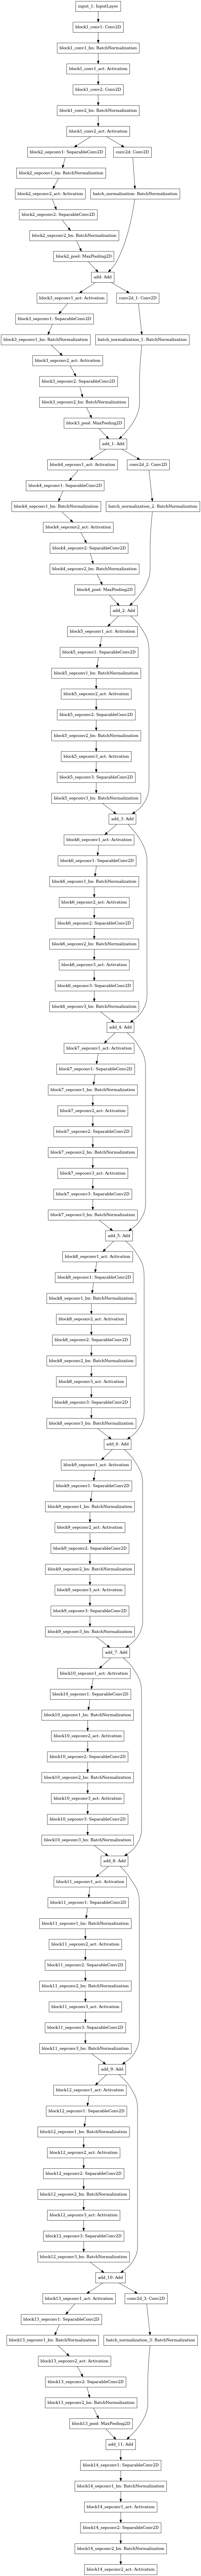

In [11]:
# Download and plot the Xception model
xception = tfk.applications.Xception(
    include_top=False, # we don't want to include the classifier 
    weights="imagenet", 
    input_shape=input_shape
)
xception.summary()
tfk.utils.plot_model(xception)


In [12]:
# We freeze the convolutional layers in order to train only our classifier 
xception.trainable = False


# Classifier
inputs = tfk.Input(input_shape)
x = tfkl.Resizing(256, 256, interpolation="bicubic")(inputs)
x = xception(x)
#instead of flattening we use a global average pooling layer (better results, see reports for details)
x = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(x) #global average pooling reduces the number of training parameters
x = tfkl.Dropout(0.3, seed=seed)(x) #dropout layer in order to reduce overfitting
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
xe= tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
xe.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
xe.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
GlobalPooling (GlobalAverage (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

In [13]:
# Train the model
xe_history = xe.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = weights,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

2022-03-10 16:23:45.607592: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/400


2022-03-10 16:23:49.121727: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


484/484 [==============================] - 194s 383ms/step - loss: 1.0238 - accuracy: 0.6691 - val_loss: 0.3630 - val_accuracy: 0.8942
Epoch 2/400
484/484 [==============================] - 164s 339ms/step - loss: 0.6545 - accuracy: 0.7869 - val_loss: 0.3630 - val_accuracy: 0.8946
Epoch 3/400
484/484 [==============================] - 165s 341ms/step - loss: 0.5725 - accuracy: 0.8110 - val_loss: 0.2726 - val_accuracy: 0.9160
Epoch 4/400
484/484 [==============================] - 165s 342ms/step - loss: 0.5354 - accuracy: 0.8281 - val_loss: 0.3398 - val_accuracy: 0.8961
Epoch 5/400
484/484 [==============================] - 168s 346ms/step - loss: 0.5076 - accuracy: 0.8343 - val_loss: 0.2133 - val_accuracy: 0.9348
Epoch 6/400
484/484 [==============================] - 168s 346ms/step - loss: 0.4917 - accuracy: 0.8382 - val_loss: 0.2293 - val_accuracy: 0.9326
Epoch 7/400
484/484 [==============================] - 167s 345ms/step - loss: 0.4809 - accuracy: 0.8390 - val_loss: 0.2753 - val_

In [14]:
xe.save("myModels/final0")

2022-03-10 19:01:03.223058: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


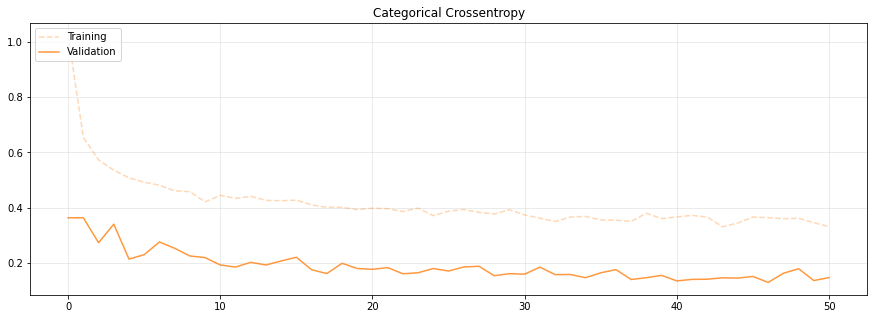

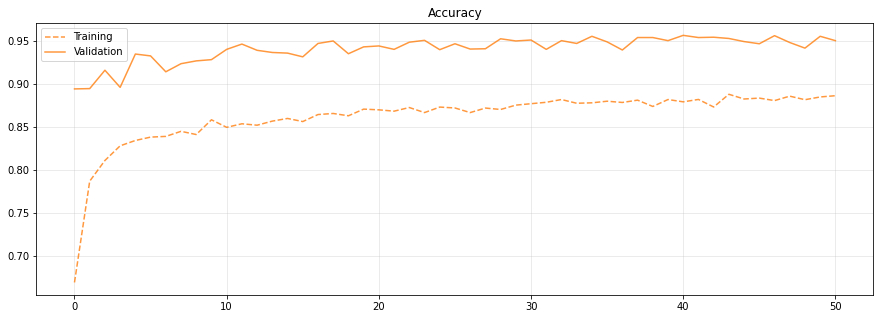

In [15]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(xe_history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(xe_history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(xe_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(xe_history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()


# Fine Tuning

In [16]:
# Set all Xception layers to True
xe.get_layer('xception').trainable = True
for i, layer in enumerate(xe.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block5_sep

In [17]:
# Freeze first 65 layers to keep the most generic filters untouched
for i, layer in enumerate(xe.get_layer('xception').layers[:65]):
  layer.trainable=False
for i, layer in enumerate(xe.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
xe.summary()


0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [18]:

# Compile the model
xe.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')


In [19]:
# Utility function to create folders and callbacks (allows to log some informations at runtime during training) for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint: allows to automatically save the model during training
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts') 
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)


  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),#where i want to save the checkpoints
                                                     save_weights_only=False, 
                                                     save_best_only=False)  

  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1) 
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=10, restore_best_weights=True)
  callbacks.append(es_callback)
    

  return callbacks

In [20]:
mycallbacks = create_folders_and_callbacks(model_name='FinalModel')

In [21]:
# Fine-tune the model
xef_history = xe.fit(
    x = train_gen,
    batch_size = 256,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = weights,
    callbacks = mycallbacks
).history

Epoch 1/400
484/484 [==============================] - 191s 388ms/step - loss: 0.3261 - accuracy: 0.8926 - val_loss: 0.0615 - val_accuracy: 0.9812


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/400
484/484 [==============================] - 189s 390ms/step - loss: 0.1574 - accuracy: 0.9462 - val_loss: 0.0328 - val_accuracy: 0.9891


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/400
484/484 [==============================] - 187s 386ms/step - loss: 0.1182 - accuracy: 0.9607 - val_loss: 0.0303 - val_accuracy: 0.9913


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/400
484/484 [==============================] - 182s 376ms/step - loss: 0.1054 - accuracy: 0.9671 - val_loss: 0.0221 - val_accuracy: 0.9928


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/400
484/484 [==============================] - 186s 383ms/step - loss: 0.0872 - accuracy: 0.9739 - val_loss: 0.0221 - val_accuracy: 0.9949


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/400
484/484 [==============================] - 182s 375ms/step - loss: 0.0748 - accuracy: 0.9756 - val_loss: 0.0266 - val_accuracy: 0.9895


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/400
484/484 [==============================] - 186s 383ms/step - loss: 0.0702 - accuracy: 0.9760 - val_loss: 0.0187 - val_accuracy: 0.9960


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/400
484/484 [==============================] - 187s 387ms/step - loss: 0.0536 - accuracy: 0.9820 - val_loss: 0.0122 - val_accuracy: 0.9967


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/400
484/484 [==============================] - 183s 377ms/step - loss: 0.0609 - accuracy: 0.9782 - val_loss: 0.0080 - val_accuracy: 0.9971


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/400
484/484 [==============================] - 181s 374ms/step - loss: 0.0471 - accuracy: 0.9843 - val_loss: 0.0143 - val_accuracy: 0.9967


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/400
484/484 [==============================] - 189s 389ms/step - loss: 0.0453 - accuracy: 0.9851 - val_loss: 0.0116 - val_accuracy: 0.9957


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


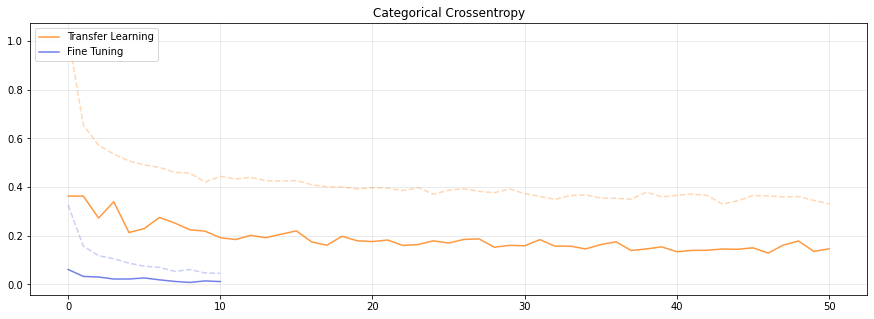

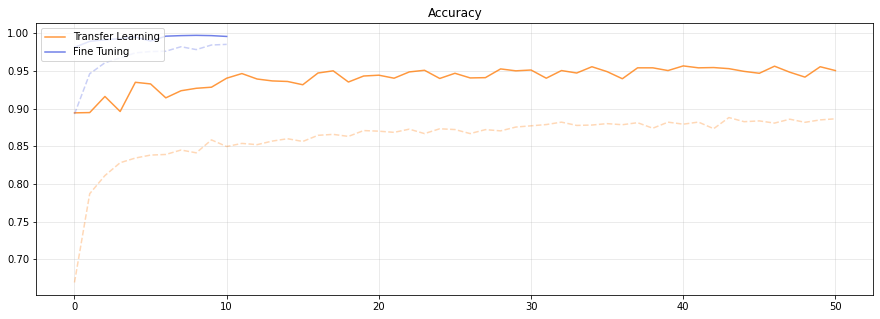

In [22]:
# Plot the training of the fined-tuned model compared with the non fined-tuned one
plt.figure(figsize=(15,5))

plt.plot(xe_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(xe_history['val_loss'], label='Transfer Learning', alpha=.8, color='#ff7f0e')

plt.plot(xef_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(xef_history['val_loss'], label='Fine Tuning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(xe_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(xe_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#ff7f0e')

plt.plot(xef_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(xef_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [23]:

xe.save("myModels/f_final0")


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Testing the model

In [24]:
# Predict the test set with the CNN
predictions = xe.predict(test_gen)
predictions.shape

(1396, 14)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix


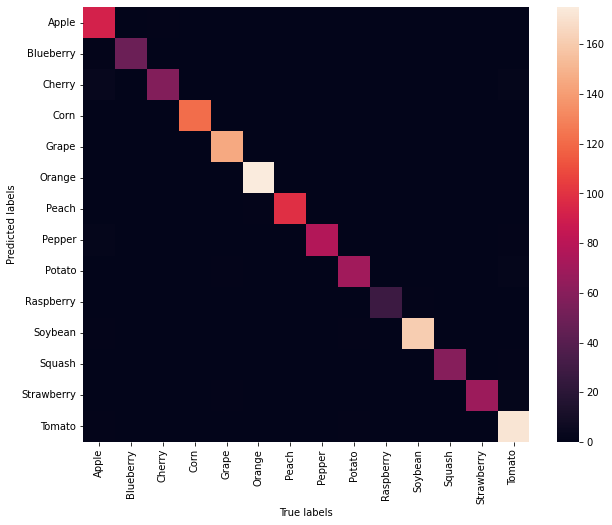

In [25]:
#Confution Matrix and Classification Report
Y_pred = xe.predict_generator(test_gen, 1786 // 20+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
plt.figure(figsize=(10,8))
cm = confusion_matrix(test_gen.classes, y_pred)
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [26]:
print('Classification Report')
print(classification_report(test_gen.classes, y_pred, target_names=labels))

Classification Report
              precision    recall  f1-score   support

       Apple       0.99      0.92      0.95       100
   Blueberry       0.98      1.00      0.99        48
      Cherry       0.92      0.98      0.95        59
        Corn       1.00      1.00      1.00       121
       Grape       1.00      0.99      0.99       147
      Orange       1.00      0.99      1.00       176
       Peach       0.99      1.00      0.99        99
      Pepper       0.96      1.00      0.98        77
      Potato       0.96      0.97      0.97        72
   Raspberry       0.97      1.00      0.98        28
     Soybean       0.99      0.99      0.99       162
      Squash       0.98      1.00      0.99        59
  Strawberry       0.96      1.00      0.98        68
      Tomato       0.99      0.96      0.97       180

    accuracy                           0.98      1396
   macro avg       0.98      0.99      0.98      1396
weighted avg       0.98      0.98      0.98      1396



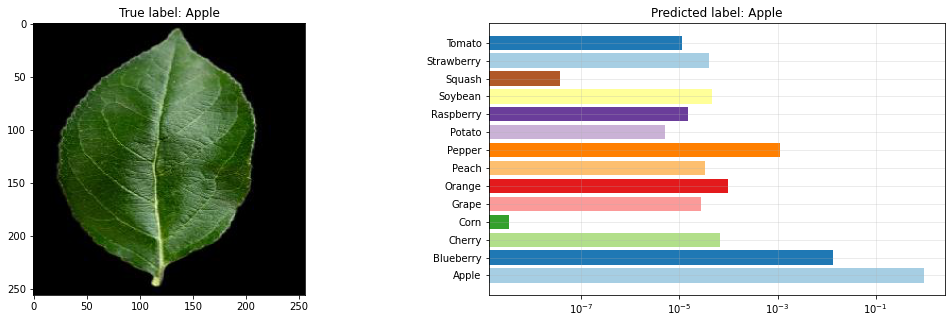

In [27]:
# Plot the target images and the predictions
batch = next(test_gen)
batch_pr = xe.predict(batch[0])
ind=random.randint(0,19)
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,5)

image = batch[0][ind]
ax1.imshow(image)
cat_label = batch[1][ind]


label_index = np.argmax(cat_label)
ax1.set_title('True label: '+labels[label_index])
ax2.barh(labels, batch_pr[ind], color=plt.get_cmap('Paired').colors, log=True)
ax2.set_title('Predicted label: '+labels[np.argmax(batch_pr[ind])])
ax2.grid(alpha=.3)
plt.show()

# Visualization

In [28]:
layers = [layer.output for layer in xe.layers[2].layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = tf.keras.Model(inputs=xe.layers[2].input, outputs=layers)
fmaps = activation_model.predict(tf.expand_dims(image, 0))

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
def display_activation(fmaps, depth=0, first_n=-1):

    fmaps = fmaps[depth] 
    if first_n > 0:
        fmaps = fmaps[0, :, :, :first_n] 
        fmaps = tf.image.resize(fmaps, size=[128, 128]) 

    # Distribute on a grid for plotting
    col_size = 8
    row_size = fmaps.shape[-1] // 8
    fmap_channel=0
    fig = plt.figure(figsize=(30, 30))
    grid = ImageGrid(fig, 111,  
                    nrows_ncols=(row_size, col_size),  
                    axes_pad=0.1,  
                    )
    for row in range(0,row_size):
        for col in range(0,col_size):
            grid[fmap_channel].imshow(fmaps[0, :, :, fmap_channel], cmap='gray', aspect='auto')
            fmap_channel += 1
    plt.show()

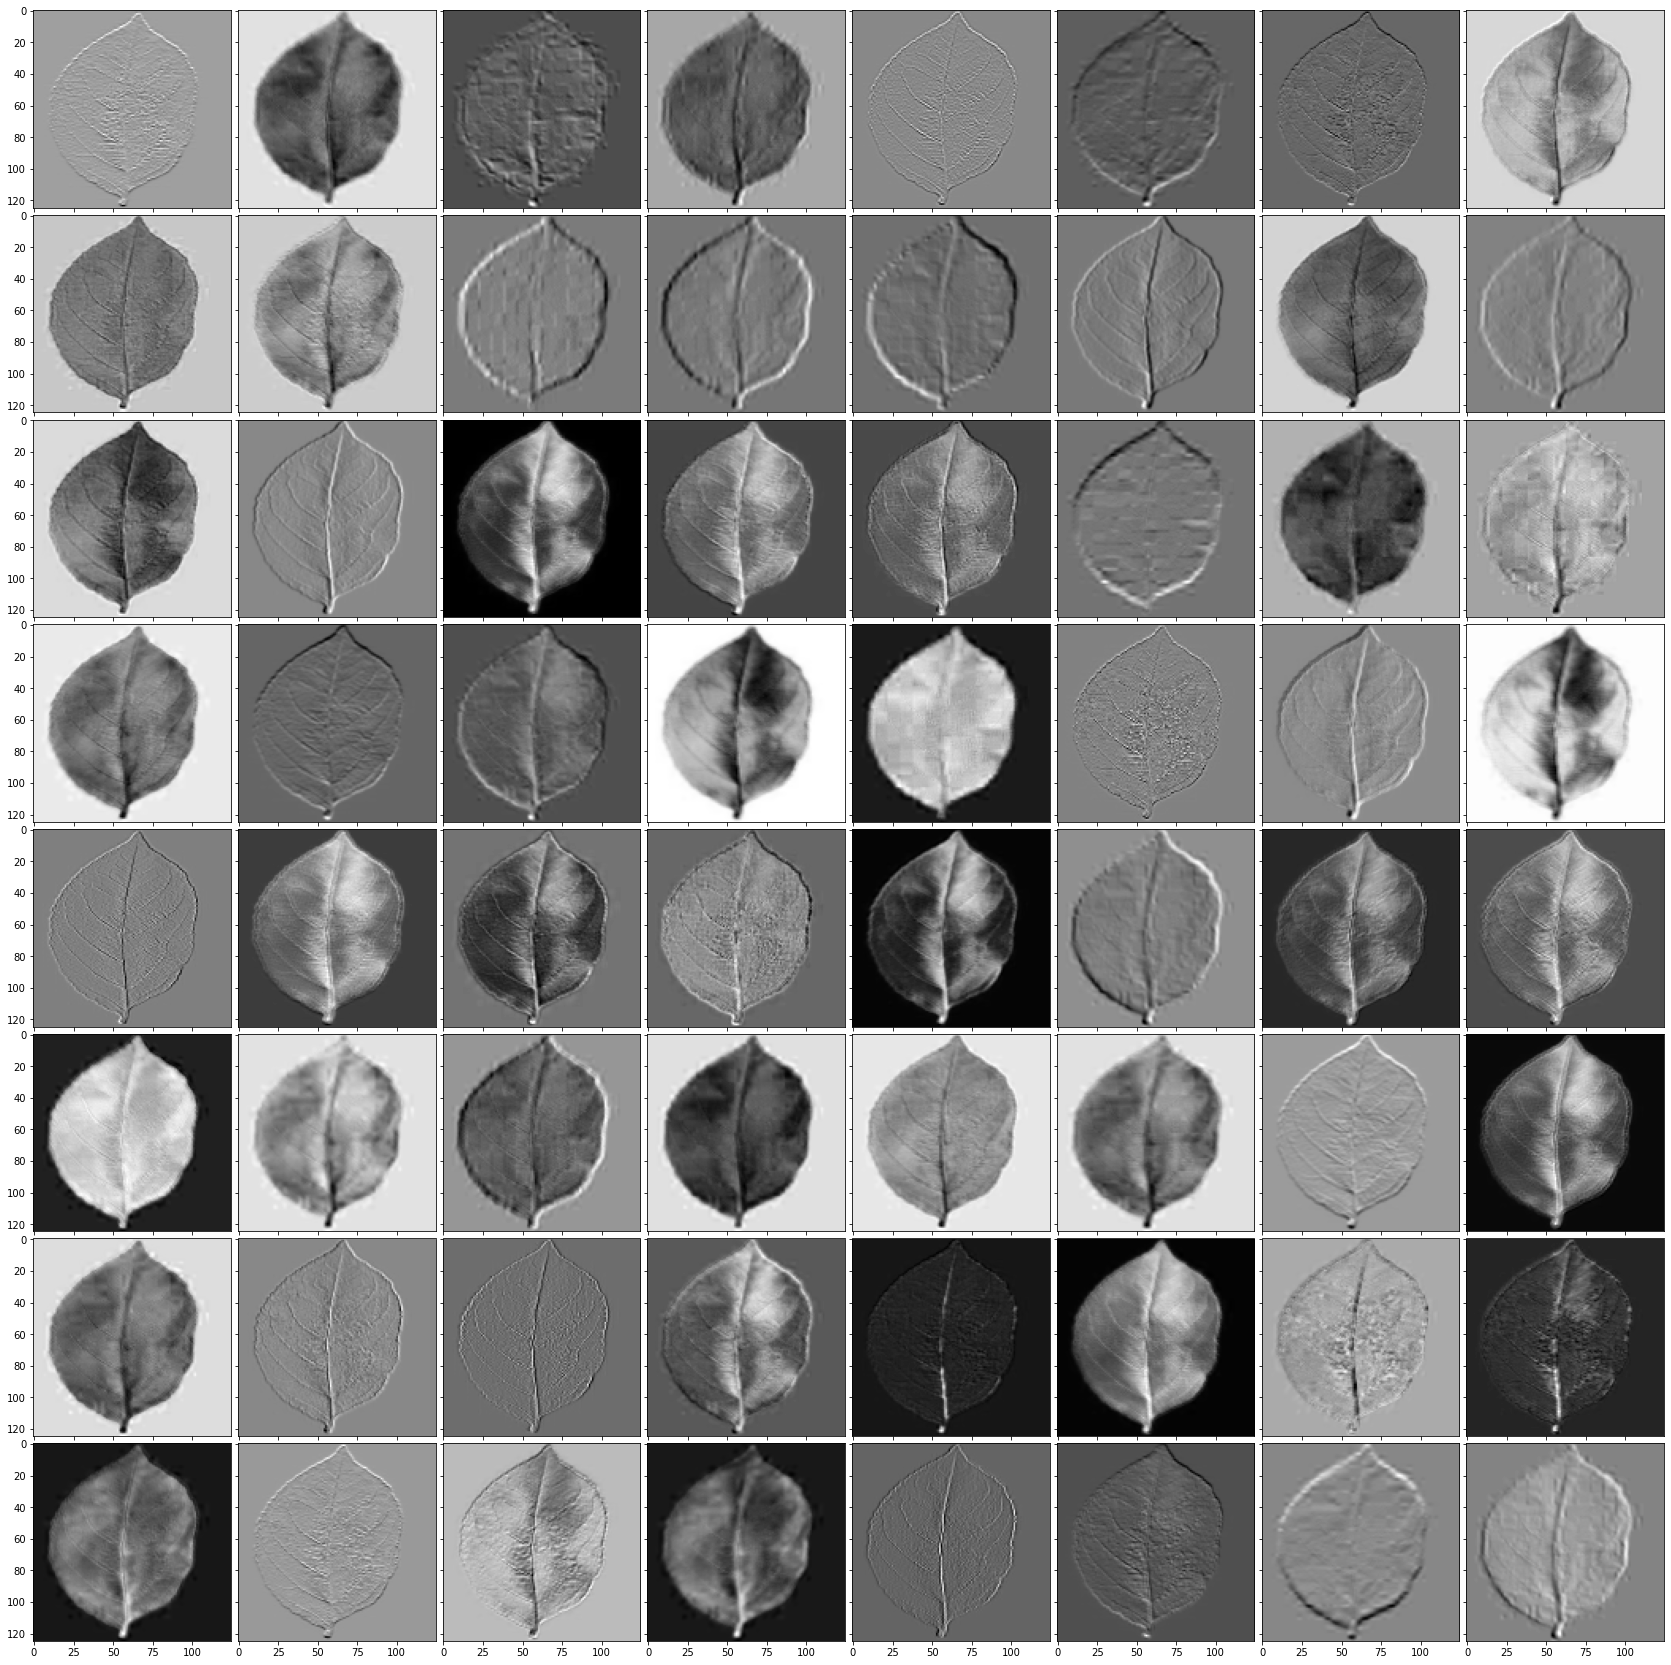

In [30]:
display_activation(fmaps=fmaps, depth=1, first_n=-1)